In [ ]:
!pip install torch torchvision wandb matplotlib opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [1]:
import os
import json
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import Compose, Resize, ToTensor, RandomHorizontalFlip, RandomRotation, Normalize
import torch.nn.functional as F
import numpy as np
import wandb

# ----- Dataset (FIXED: No normalization on targets) -----
class PolygonColorDataset(Dataset):
    def __init__(self, root_dir, split='training', transform=None, color_map=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.color_map = color_map or {}
        json_path = os.path.join(root_dir, split, 'data.json')
        with open(json_path, 'r') as f:
            self.data = json.load(f)
        if not self.color_map:
            colors = sorted(list({item["colour"] for item in self.data}))
            self.color_map = {color: idx for idx, color in enumerate(colors)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        input_name = item["input_polygon"]
        color_name = item["colour"]
        output_name = item["output_image"]
        input_path = os.path.join(self.root_dir, self.split, 'inputs', input_name)
        output_path = os.path.join(self.root_dir, self.split, 'outputs', output_name)

        input_image = Image.open(input_path).convert('RGB')
        output_image = Image.open(output_path).convert('RGB')

        # Apply transform to input only, keep output in [0,1] range
        if self.transform:
            input_image = self.transform(input_image)

        # Convert output to tensor without normalization
        output_tensor = ToTensor()(output_image)

        color_idx = self.color_map[color_name]
        return input_image, torch.tensor(color_idx, dtype=torch.long), output_tensor

In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

In [3]:
class ConditionalUNet(nn.Module):
    def __init__(self, input_channels=3, base_channels=128, num_colors=10, embedding_dim=32):
        super().__init__()
        self.color_emb = nn.Embedding(num_colors, embedding_dim)
        self.down1 = DoubleConv(input_channels + embedding_dim, base_channels)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(base_channels, base_channels*2)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(base_channels*2, base_channels*4)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(base_channels*4, base_channels*8)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(base_channels*8, base_channels*16)

        self.up4 = nn.ConvTranspose2d(base_channels*16, base_channels*8, 2, 2)
        self.conv4 = DoubleConv(base_channels*16, base_channels*8)
        self.up3 = nn.ConvTranspose2d(base_channels*8, base_channels*4, 2, 2)
        self.conv3 = DoubleConv(base_channels*8, base_channels*4)
        self.up2 = nn.ConvTranspose2d(base_channels*4, base_channels*2, 2, 2)
        self.conv2 = DoubleConv(base_channels*4, base_channels*2)
        self.up1 = nn.ConvTranspose2d(base_channels*2, base_channels, 2, 2)
        self.conv1 = DoubleConv(base_channels*2, base_channels)

        # Final layers for sharp output
        self.final_conv = nn.Sequential(
            nn.Conv2d(base_channels, base_channels//2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels//2, 3, 1),
            nn.Sigmoid()  # Keep sigmoid since targets are [0,1]
        )

    def forward(self, x, color_idx):
        B, C, H, W = x.shape
        color_vec = self.color_emb(color_idx)
        color_broadcast = color_vec.view(B, -1, 1, 1).expand(-1, -1, H, W)
        x = torch.cat([x, color_broadcast], dim=1)

        d1 = self.down1(x); p1 = self.pool1(d1)
        d2 = self.down2(p1); p2 = self.pool2(d2)
        d3 = self.down3(p2); p3 = self.pool3(d3)
        d4 = self.down4(p3); p4 = self.pool4(d4)

        b = self.bottleneck(p4)

        up4 = self.up4(b)
        cat4 = torch.cat([up4, d4], 1)
        c4 = self.conv4(cat4)

        up3 = self.up3(c4)
        cat3 = torch.cat([up3, d3], 1)
        c3 = self.conv3(cat3)

        up2 = self.up2(c3)
        cat2 = torch.cat([up2, d2], 1)
        c2 = self.conv2(cat2)

        up1 = self.up1(c2)
        cat1 = torch.cat([up1, d1], 1)
        c1 = self.conv1(cat1)

        out = self.final_conv(c1)
        return out

In [4]:
class CombinedLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_loss = nn.L1Loss()
        self.mse_loss = nn.MSELoss()

    def forward(self, pred, target):
        l1 = self.l1_loss(pred, target)
        mse = self.mse_loss(pred, target)

        # Vertical edges: shape [B,C,H-1,W]
        pred_vert = torch.abs(pred[:, :, 1:, :] - pred[:, :, :-1, :])
        target_vert = torch.abs(target[:, :, 1:, :] - target[:, :, :-1, :])
        vert_loss = self.l1_loss(pred_vert, target_vert)

        # Horizontal edges: shape [B,C,H,W-1]
        pred_horz = torch.abs(pred[:, :, :, 1:] - pred[:, :, :, :-1])
        target_horz = torch.abs(target[:, :, :, 1:] - target[:, :, :, :-1])
        horz_loss = self.l1_loss(pred_horz, target_horz)

        edge_loss = (vert_loss + horz_loss) * 0.5

        return l1 + 0.5 * mse + 0.3 * edge_loss

In [5]:
def psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    if mse == 0: return 100
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

In [6]:
def unnormalize_input(img):
    return img * 0.5 + 0.5

In [7]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0
    for imgs, color_idx, gts in dataloader:
        imgs = imgs.to(device)
        gts = gts.to(device)
        color_idx = color_idx.to(device)
        optimizer.zero_grad()
        preds = model(imgs, color_idx)
        loss = criterion(preds, gts)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    return running_loss / len(dataloader.dataset)

In [8]:
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0
    running_psnr = 0
    num_samples = 0
    with torch.no_grad():
        for imgs, color_idx, gts in dataloader:
            imgs = imgs.to(device)
            gts = gts.to(device)
            color_idx = color_idx.to(device)
            preds = model(imgs, color_idx)
            loss = criterion(preds, gts)
            running_loss += loss.item() * imgs.size(0)
            for i in range(imgs.size(0)):
                running_psnr += psnr(preds[i:i+1], gts[i:i+1])
            num_samples += imgs.size(0)
    return running_loss / num_samples, running_psnr / num_samples

In [9]:
if __name__ == '__main__':
    import argparse
    def parse_args_notebook():
        parser = argparse.ArgumentParser()
        parser.add_argument('--data_root', type=str, default='/content/drive/MyDrive/Ayna Dataset/dataset')
        parser.add_argument('--batch_size', type=int, default=8)  # Reduced for stability
        parser.add_argument('--epochs', type=int, default=50)    # More epochs
        parser.add_argument('--lr', type=float, default=2e-4)     # Lower LR for stability
        args = parser.parse_args(args=[])
        return args

    args = parse_args_notebook()
    wandb.init(project="aynalab-coloured-polygon")

    # Only normalize inputs, not targets
    norm = Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
    train_transform = Compose([
       Resize((128, 128)),
       RandomHorizontalFlip(p=0.3),  # Reduced probability
       ToTensor(),
       norm
    ])
    val_transform = Compose([
       Resize((128, 128)),
       ToTensor(),
       norm
    ])

    train_dataset = PolygonColorDataset(args.data_root, split='training', transform=train_transform)
    val_dataset = PolygonColorDataset(args.data_root, split='validation', transform=val_transform, color_map=train_dataset.color_map)

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Enhanced model with larger capacity
    model = ConditionalUNet(3, 128, len(train_dataset.color_map), 32).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # Enhanced loss function
    criterion = CombinedLoss()

    best_val_loss = float('inf')
    for epoch in range(args.epochs):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_psnr = validate_epoch(model, val_loader, criterion, device)
        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{args.epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val PSNR: {val_psnr:.4f}')
        wandb.log({
            'epoch': epoch+1,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_psnr': val_psnr.item(),
        })

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_conditional_unet.pth')

    # Final model save
    torch.save(model.state_dict(), 'final_conditional_unet.pth')
    wandb.save('best_conditional_unet.pth')

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: prathameshdhote773 (prathameshdhote773-rajiv-gandhi-institute-of-petroleum-t) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Train Loss: 0.5546, Val Loss: 0.6071, Val PSNR: 6.2436
Epoch 2/50, Train Loss: 0.3983, Val Loss: 0.4784, Val PSNR: 7.9057
Epoch 3/50, Train Loss: 0.2861, Val Loss: 0.2738, Val PSNR: 11.4054
Epoch 4/50, Train Loss: 0.2168, Val Loss: 0.2125, Val PSNR: 11.9214
Epoch 5/50, Train Loss: 0.1835, Val Loss: 0.2382, Val PSNR: 12.1255
Epoch 6/50, Train Loss: 0.1591, Val Loss: 0.2132, Val PSNR: 12.3024
Epoch 7/50, Train Loss: 0.1488, Val Loss: 0.1621, Val PSNR: 13.5732
Epoch 8/50, Train Loss: 0.1411, Val Loss: 0.2954, Val PSNR: 10.5870
Epoch 9/50, Train Loss: 0.1352, Val Loss: 0.1431, Val PSNR: 13.2508
Epoch 10/50, Train Loss: 0.1302, Val Loss: 0.1141, Val PSNR: 13.0713
Epoch 11/50, Train Loss: 0.1299, Val Loss: 0.1047, Val PSNR: 13.4404
Epoch 12/50, Train Loss: 0.1259, Val Loss: 0.1335, Val PSNR: 13.3710
Epoch 13/50, Train Loss: 0.1208, Val Loss: 0.1268, Val PSNR: 13.6004
Epoch 14/50, Train Loss: 0.1177, Val Loss: 0.0918, Val PSNR: 15.2726
Epoch 15/50, Train Loss: 0.1102, Val Loss: 0.

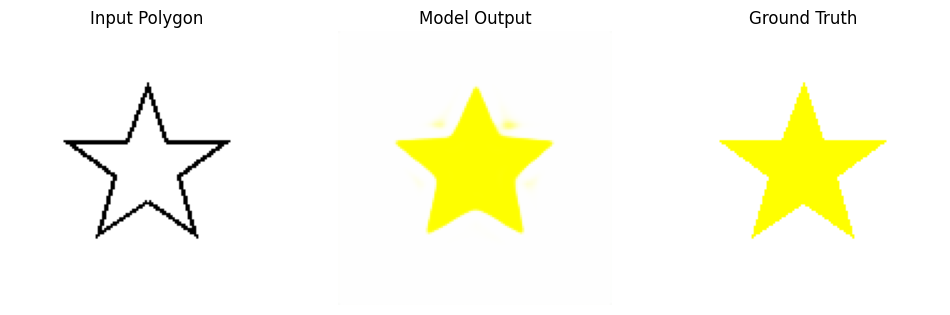

In [11]:
    model.eval()
    input_tensor, color_idx, target_tensor = val_dataset[0]
    with torch.no_grad():
        pred = model(input_tensor.unsqueeze(0).to(device), color_idx.unsqueeze(0).to(device)).cpu().squeeze(0)

    pred_img = pred.permute(1, 2, 0).numpy()
    true_img = target_tensor.permute(1, 2, 0).numpy()
    in_img = unnormalize_input(input_tensor).permute(1, 2, 0).numpy()

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Input Polygon")
    plt.axis('off')
    plt.imshow(np.clip(in_img, 0, 1))
    plt.subplot(1, 3, 2)
    plt.title("Model Output")
    plt.axis('off')
    plt.imshow(np.clip(pred_img, 0, 1))
    plt.subplot(1, 3, 3)
    plt.title("Ground Truth")
    plt.axis('off')
    plt.imshow(np.clip(true_img, 0, 1))
    plt.show()


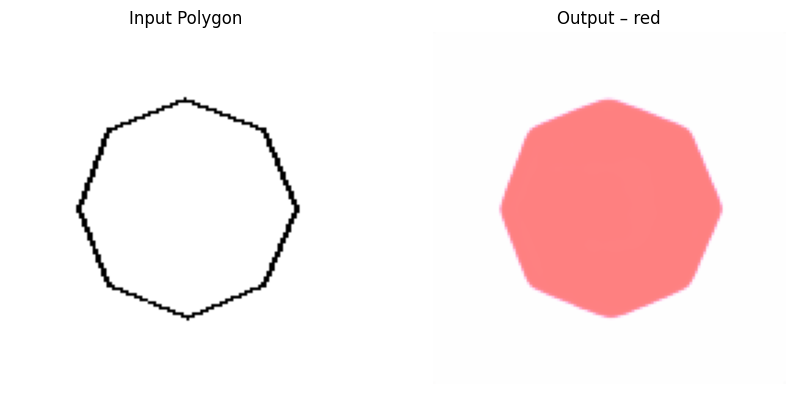

In [12]:
def load_model(model_path, num_colors, device):
    model = ConditionalUNet(
        input_channels=3,
        base_channels=128,     # must match training
        num_colors=num_colors,
        embedding_dim=32       # must match training
    )
    model.load_state_dict(torch.load(model_path, map_location=device))
    return model.to(device).eval()

def infer_and_display(model, color_map, input_image_path, color_name, device):
    # Preprocess
    transform = Compose([
        Resize((128, 128)),
        ToTensor(),
        Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])
    img = Image.open(input_image_path).convert('RGB')
    img_t = transform(img).unsqueeze(0).to(device)
    color_idx = torch.tensor([color_map[color_name]], dtype=torch.long).to(device)

    # Forward pass
    with torch.no_grad():
        output = model(img_t, color_idx)

    # Prepare for display
    input_vis = np.array(img)
    output_np = output.cpu().squeeze().permute(1,2,0).numpy()
    # Undo normalization
    output_np = (output_np * 0.5 + 0.5)
    output_np = np.clip(output_np, 0, 1)

    # Plot
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title('Input Polygon')
    plt.axis('off')
    plt.imshow(input_vis)
    plt.subplot(1,2,2)
    plt.title(f'Output – {color_name}')
    plt.axis('off')
    plt.imshow(output_np)
    plt.show()

# Usage example:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
color_map = train_dataset.color_map
model = load_model('best_conditional_unet.pth', num_colors=len(color_map), device=device)

# Replace these with your desired test image and color:
input_image_path = '/content/drive/MyDrive/Ayna Dataset/dataset/validation/inputs/octagon.png'
color_name = 'red'

infer_and_display(model, color_map, input_image_path, color_name, device)